In [1]:
# ========= 1) 环境与导入（含 sys.path 注入） =========
import sys
import os
import importlib
from pathlib import Path
from unittest.mock import MagicMock
import warnings

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

# 方案根目录：degree_code/scheme_1
_cwd = Path.cwd().resolve()
scheme_root = None
for p in [_cwd, *_cwd.parents]:
    if (p / 'TPLC_Net').exists() and (p / 'baselines').exists():
        scheme_root = p
        break
if scheme_root is None:
    raise RuntimeError('找不到 scheme_1 根目录（需要同时包含 TPLC_Net/ 与 baselines/）。')

tplc_net_root = scheme_root / 'TPLC_Net'
baselines_root = scheme_root / 'baselines'
ts_lib_root = Path(r'D:\Time_Series_Library\Time-Series-Library')  # TSLib 路径

# === 🌟 关键修复：清除可能被污染的 modules 缓存 ===
# TimeMixer/TimeMixer++ 根目录下都有 layers.py，容易与 TSLib 的 layers 包冲突。
# 必须先清除缓存，并确保 TSLib 在 sys.path 最前面。
for mod in ['layers', 'models', 'utils.tools']:
    if mod in sys.modules:
        del sys.modules[mod]
    # 清除子模块
    keys = list(sys.modules.keys())
    for k in keys:
        if k.startswith(f"{mod}."):
            del sys.modules[k]

# === 1. 优先加载 TSLib ===
if str(ts_lib_root) not in sys.path:
    sys.path.insert(0, str(ts_lib_root))
else:
    sys.path.remove(str(ts_lib_root))
    sys.path.insert(0, str(ts_lib_root))

# Mock TSLib 依赖
try:
    import reformer_pytorch
except ImportError:
    sys.modules['reformer_pytorch'] = MagicMock()
    sys.modules['reformer_pytorch'].LSHSelfAttention = MagicMock()
try:
    import einops
except ImportError:
    sys.modules['einops'] = MagicMock()

# 尝试导入 PatchTST (此时 layers 应该解析为 TSLib 的包)
PatchTSTModel = None
try:
    from models.PatchTST import Model as PatchTSTModel
    print("✅ Successfully imported PatchTSTModel")
except ImportError as e:
    print(f"❌ PatchTST import failed: {e}")
    # 尝试打印调试信息
    try:
        import layers
        print(f"Debug: 'layers' module path: {layers.__file__}")
    except:
        pass

# === 2. 加载其余模块 ===
# 注意：TimeMixer++ 只能 append 到后面，防止它的 layers.py 覆盖 PatchTST 的 layers 包
sys.path.append(str(baselines_root))
sys.path.append(str(tplc_net_root))

# TimeMixer++ (名字带特殊字符，只能加路径)
timemixer_pp_root = baselines_root / 'TimeMixer++'
if str(timemixer_pp_root) not in sys.path:
    sys.path.append(str(timemixer_pp_root))

# TimeMixer (Original) - 通过 baselines 导入即可，不要加它的根路径，否则 layers.py 会再次污染
# 如果 sys.path 已经有了 timemixer_root (可能由旧代码引入)，尝试移除
timemixer_root = baselines_root / 'TimeMixer'
if str(timemixer_root) in sys.path:
    sys.path.remove(str(timemixer_root))

# 导入本地模块
from tplc_algo.exp_utils import create_run_dir, save_json
from tplc_algo.data import GreenhouseMergedDataset, load_team_merged_dataframe
from tplc_algo.data.greenhouse_dataset import WindowSpec
from tplc_algo.utils import NumpyStandardScaler
from tplc_algo.models import TPLCNet
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.tuner import tune_tplcnet_random_search

# Baselines
from LSTM import LSTMForecaster
from TimesNet import TimesNetForecaster
from timemixer_pp_algo.config import TimeMixerPPConfig
from timemixer_pp_algo.model import TimeMixerPPForecaster

# 导入 TimeMixer (Original)
try:
    from TimeMixer import TimeMixerForecaster, TimeMixerConfig
    print("✅ Successfully imported TimeMixerForecaster (Original)")
except ImportError:
    # 兼容旧的文件结构（如果 TimeMixer 不是包）
    if str(timemixer_root) not in sys.path:
         sys.path.append(str(timemixer_root))
    from timemixer import TimeMixerForecaster, TimeMixerConfig
    print("⚠️ Imported TimeMixerForecaster via legacy path")

print('scheme_root =', scheme_root)
print('torch =', torch.__version__, 'cuda =', torch.cuda.is_available())

✅ Successfully imported PatchTSTModel
✅ Successfully imported TimeMixerForecaster (Original)
scheme_root = D:\degree_code\scheme_1
torch = 2.5.1+cu121 cuda = True


In [2]:
# ========= 2) 实验配置 =========
import json

team = 'AICU'
seq_len = 96
pred_len = 24
stride = 1
batch_size = 32
epochs = 20

# 默认超参数（手动更新为最近最优 Trial 1: hidden_dim=32, top_k=4, num_scales=1, lr=0.0022）
lr = 0.0022
weight_decay = 0.0
hidden_dim = 32
top_k_periods = 4
num_scales = 1

# ===== 尝试从 TPLC_Net/best_params.json 加载最新调参结果 =====
# 这样保证每次 run_TPLC_greenhouse.ipynb 跑完后，这里能自动同步
try:
    best_params_path = scheme_root / 'TPLC_Net' / 'best_params.json'
    if best_params_path.exists():
        print(f"检测到自动调参结果文件: {best_params_path}")
        with open(best_params_path, 'r', encoding='utf-8') as f:
            best_params = json.load(f)
        
        # 更新参数
        old_cfg = (hidden_dim, top_k_periods, num_scales, lr)
        
        hidden_dim = int(best_params.get('hidden_dim', hidden_dim))
        top_k_periods = int(best_params.get('top_k_periods', top_k_periods))
        num_scales = int(best_params.get('num_scales', num_scales))
        lr = float(best_params.get('lr', lr))
        weight_decay = float(best_params.get('weight_decay', weight_decay))
        
        new_cfg = (hidden_dim, top_k_periods, num_scales, lr)
        if old_cfg != new_cfg:
            print(f"✅ 已应用最新调参超参: {best_params}")
        else:
            print(f"ℹ️ 当前配置已是最新。")
    else:
        print(f"⚠️ 未找到 {best_params_path}，使用脚本内默认配置。")
except Exception as e:
    print(f"❌ 加载 best_params.json 失败: {e}，将使用默认配置。")


# ===== TPLCNet 自动调参（本地微调开关） =====
do_tune_tplc = False
tune_trials = 10
tune_trial_epochs = 5

# LSTM
lstm_hidden = 128
lstm_layers = 2

# TimesNet (优化为轻量级配置，参考官方脚本)
timesnet_d_model = 32  # 原 64 -> 32
timesnet_d_ff = 64     # 原 128 -> 64
timesnet_e_layers = 2
timesnet_top_k = 5     # 原 3 -> 5
timesnet_num_kernels = 6
timesnet_dropout = 0.1

# PatchTST 配置
patchtst_d_model = 128
patchtst_n_heads = 4
patchtst_e_layers = 2
patchtst_d_ff = 256
patchtst_dropout = 0.1
patchtst_patch_len = 16
patchtst_stride = 8

# 训练稳定性配置
use_amp = False
grad_clip_max_norm = 1.0
lr_scheduler = 'plateau'
plateau_patience = 3
plateau_factor = 0.5
early_stop_patience = 6

dataset_root = (scheme_root / 'datasets' / '自主温室挑战赛').resolve()
team_dir = dataset_root / team
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 总实验目录（修改：保存到 compare_result 并附加时间戳）
compare_result_dir = scheme_root / 'compare_result'
# create_run_dir 自动生成：<base_dir>/<exp_name>_<Ymd_HMS>
run_dir = create_run_dir(
    exp_name=f'compare_tplc_lstm_timesnet_patchtst_{team}_v3', 
    base_dir=compare_result_dir
)

print('team_dir =', team_dir)
print('run_dir  =', run_dir)
print('device   =', device)
print(f'最终生效配置: hidden_dim={hidden_dim}, top_k={top_k_periods}, num_scales={num_scales}')
print(f'训练配置: epochs={epochs}, lr={lr:.6f}, grad_clip={grad_clip_max_norm}')

⚠️ 未找到 D:\degree_code\scheme_1\TPLC_Net\best_params.json，使用脚本内默认配置。
team_dir = D:\degree_code\scheme_1\datasets\自主温室挑战赛\AICU
run_dir  = D:\degree_code\scheme_1\compare_result\compare_tplc_lstm_timesnet_patchtst_AICU_v3_20260115_163412
device   = cuda
最终生效配置: hidden_dim=32, top_k=4, num_scales=1
训练配置: epochs=20, lr=0.002200, grad_clip=1.0


In [3]:
# ========= 3) 数据加载/对齐 =========
merged_df = load_team_merged_dataframe(team_dir)
print('merged_df shape:', merged_df.shape)
print('columns:', list(merged_df.columns)[:20], '...')

# 检查数据中是否有 NaN
if merged_df.isnull().values.any():
    print("⚠️ 警告：原始数据中包含 NaN 值！正在进行填充...")
    merged_df = merged_df.fillna(method='ffill').fillna(method='bfill').fillna(0)
    print("NaN 值已填充。")
else:
    print("数据完整性检查通过：无 NaN 值。")

merged_df.head()

D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


merged_df shape: (47809, 120)
columns: ['time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC', 'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR', 'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip', 'co2_dos', 'co2_sp'] ...
数据完整性检查通过：无 NaN 值。


,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,CO2_cons,Irr,Drain,Flavour,TSS,Acid,%Juice,Bite,Weight,DMC_fruit
0,43815.00000,100.0,35.0,509.0,31.6,0.3,96.0,8.8,0.0,49.9,...,0.005477,16.2,0.0,80.0,9.0,14.5,67.0,219.0,9.0,8.73
1,43815.00347,100.0,85.0,484.0,31.8,0.3,96.0,9.2,0.0,48.5,...,0.005477,16.2,0.0,80.0,9.0,14.5,67.0,219.0,9.0,8.73
2,43815.00694,100.0,96.0,475.0,31.8,0.3,96.0,9.1,0.0,46.8,...,0.005477,16.2,0.0,80.0,9.0,14.5,67.0,219.0,9.0,8.73
3,43815.01042,100.0,96.0,501.0,32.0,0.3,96.0,8.5,0.0,45.2,...,0.005477,16.2,0.0,80.0,9.0,14.5,67.0,219.0,9.0,8.73
4,43815.01389,100.0,96.0,487.0,32.0,0.3,96.0,8.5,0.0,43.8,...,0.005477,16.2,0.0,80.0,9.0,14.5,67.0,219.0,9.0,8.73


In [4]:
# ========= 4) 特征/目标选择 =========

# --- 核心修改：读取 Config 中的特征定义 ---
from tplc_algo.config import TPLCConfig

# 如果 Config 中定义了 feature_cols（无论是元组还是列表），就用它
# 否则默认使用所有非 'time' 列
if TPLCConfig.feature_cols:
    selected_features = list(TPLCConfig.feature_cols)
    # 确保这些列确实在 dataframe 里存在
    feature_cols = [c for c in selected_features if c in merged_df.columns]
    
    # 打印一下被忽略的列（方便排查）
    missing_cols = set(selected_features) - set(feature_cols)
    if missing_cols:
        print(f"⚠️ Config 中定义的特征缺少: {missing_cols}")
else:
    feature_cols = [c for c in merged_df.columns if c != 'time']

# 同样逻辑处理 Target Cols
if TPLCConfig.target_cols:
    target_cols = [c for c in TPLCConfig.target_cols if c in merged_df.columns]
else:
    preferred_targets = ['Tair', 'Rhair', 'CO2air']
    target_cols = [c for c in preferred_targets if c in merged_df.columns]
    if len(target_cols) == 0:
        target_cols = feature_cols[:3] # 兜底

print('input_dim =', len(feature_cols))
print('feature_cols =', feature_cols)
print('target_dim =', len(target_cols), target_cols)

input_dim = 12
feature_cols = ['Tair', 'Rhair', 'CO2air', 'VentLee', 'Ventwind', 'PipeGrow', 'PipeLow', 'co2_dos', 'AssimLight', 'EnScr', 'BlackScr', 'Tot_PAR']
target_dim = 3 ['Tair', 'Rhair', 'CO2air']


In [5]:
# ========= 5) 划分 train/val/test（时间顺序）+ 标准化 =========
n = len(merged_df)
n_train = int(n * 0.7)
n_val = int(n * 0.1)

train_df = merged_df.iloc[:n_train].reset_index(drop=True)
val_df = merged_df.iloc[n_train:n_train+n_val].reset_index(drop=True)
test_df = merged_df.iloc[n_train+n_val:].reset_index(drop=True)
print('split:', len(train_df), len(val_df), len(test_df))

all_scaler = NumpyStandardScaler().fit(train_df[feature_cols].to_numpy(np.float32))

# 创建 target_scaler（用于反标准化预测结果）
target_indices = [feature_cols.index(c) for c in target_cols]
target_scaler = NumpyStandardScaler(mean_=all_scaler.mean_[target_indices], std_=all_scaler.std_[target_indices])

def apply_scalers(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out[feature_cols] = all_scaler.transform(out[feature_cols].to_numpy(np.float32))
    return out

train_df_s = apply_scalers(train_df)
val_df_s = apply_scalers(val_df)
test_df_s = apply_scalers(test_df)

print(f'target_scaler 已创建，目标特征：{target_cols}')

split: 33466 4780 9563
target_scaler 已创建，目标特征：['Tair', 'Rhair', 'CO2air']


In [6]:
# ========= 6) Dataset & DataLoader =========
window = WindowSpec(seq_len=seq_len, pred_len=pred_len, stride=stride)
train_ds = GreenhouseMergedDataset(train_df_s, window, feature_cols=feature_cols, target_cols=target_cols)
val_ds = GreenhouseMergedDataset(val_df_s, window, feature_cols=feature_cols, target_cols=target_cols)
test_ds = GreenhouseMergedDataset(test_df_s, window, feature_cols=feature_cols, target_cols=target_cols)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print('train batches:', len(train_loader), 'val:', len(val_loader), 'test:', len(test_loader))

train batches: 1042 val: 146 test: 296


In [7]:
# ========= 7) 训练/评估工具函数（改进版） =========
from tplc_algo.exp_utils import save_config_json, save_env_json, save_history_csv, save_metrics_json, save_text


def _ensure_run_subdirs(model_dir: Path) -> None:
    (model_dir / 'checkpoints').mkdir(parents=True, exist_ok=True)
    (model_dir / 'figures').mkdir(parents=True, exist_ok=True)
    (model_dir / 'artifacts').mkdir(parents=True, exist_ok=True)


def train_eval_one(
    model_name: str,
    model: torch.nn.Module,
    *,
    lr_override: float | None = None,
    weight_decay_override: float | None = None,
    extra_config: dict | None = None,
) -> dict:
    """训练一个模型并落盘结果。

    额外输出：
    - metrics['mae_raw'] / metrics['rmse_raw']：反标准化回原始量纲后的 MAE/RMSE（更直观）
    """

    model_dir = Path(run_dir) / model_name
    _ensure_run_subdirs(model_dir)
    ckpt_path = model_dir / 'checkpoints' / 'best.pt'

    lr_used = float(lr if lr_override is None else lr_override)
    wd_used = float(weight_decay if weight_decay_override is None else weight_decay_override)

    # 🔧 改进：添加完整的训练稳定性配置
    trainer = Trainer(
        model=model,
        cfg=TrainConfig(
            epochs=epochs,
            lr=lr_used,
            weight_decay=wd_used,
            device=device,
            ckpt_path=ckpt_path,
            show_progress=True,
            progress_granularity='epoch',  # 改为 epoch 级别，更清晰
            # 训练稳定性增强
            grad_clip_max_norm=grad_clip_max_norm,
            use_amp=use_amp and device == 'cuda',
            lr_scheduler=lr_scheduler,
            plateau_patience=plateau_patience,
            plateau_factor=plateau_factor,
            early_stop_patience=early_stop_patience,
        ),
    )

    history = trainer.fit(train_loader, val_loader=val_loader)
    metrics = trainer.evaluate(test_loader)

    # 额外：反标准化指标（raw space）
    # 说明：数据集的 y/y_hat 都在标准化空间；这里用 train 拟合得到的 target_scaler 反标准化。
    model.eval()
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y_hat = model(x).detach().cpu().numpy()  # [B, pred, D]
            y_true_list.append(y.detach().cpu().numpy())
            y_pred_list.append(y_hat)

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    y_true_raw = target_scaler.inverse_transform(y_true.reshape(-1, len(target_cols))).reshape(y_true.shape)
    y_pred_raw = target_scaler.inverse_transform(y_pred.reshape(-1, len(target_cols))).reshape(y_pred.shape)

    metrics['mae_raw'] = float(np.mean(np.abs(y_true_raw - y_pred_raw)))
    metrics['rmse_raw'] = float(np.sqrt(np.mean((y_true_raw - y_pred_raw) ** 2)))

    cfg = {
        'model_name': model_name,
        'train': {
            'epochs': epochs,
            'lr': lr_used,
            'weight_decay': wd_used,
            'device': device,
            'grad_clip_max_norm': grad_clip_max_norm,
            'use_amp': use_amp,
            'lr_scheduler': lr_scheduler,
            'early_stop_patience': early_stop_patience,
        },
    }
    if extra_config is not None:
        cfg.update(extra_config)

    save_config_json(model_dir, cfg)
    save_env_json(model_dir)
    save_history_csv(model_dir, history)
    save_metrics_json(model_dir, metrics)
    save_text(model_dir / 'artifacts' / 'checkpoint_path.txt', str(ckpt_path))

    return {'history': history, 'metrics': metrics, 'model_dir': str(model_dir), 'train_cfg': cfg.get('train', {})}

## TPLC vs TimesNet 关键差异分析

基于 TimesNet 的成功经验，TPLC 模型可能存在以下问题：

### 1. **训练稳定性配置缺失**
- ❌ TPLC: 没有梯度裁剪、学习率调度、早停等
- ✅ TimesNet: 使用 `grad_clip=1.0`, `lr_scheduler='plateau'`, `early_stop_patience=6`

### 2. **训练轮数不足**
- ❌ TPLC: 仅训练 5 轮（调参时只有 2 轮）
- ✅ TimesNet: 训练 20 轮，足够收敛

### 3. **模型架构问题**
- TPLC 使用平均池化下采样，可能丢失高频信息
- TPLC 的多尺度融合初始权重为等权，可能不够灵活
- TPLC 缺少残差连接（TimesNet 有 `res = res + x`）

### 4. **激活函数和正则化**
- TPLC 使用 GELU + BatchNorm
- TimesNet 也使用 GELU，但还有 Dropout 正则化

### 建议改进（按优先级）：
1. **立即改进**：增加训练稳定性配置（梯度裁剪、学习率调度、早停）
2. **增加训练轮数**：从 5 轮提升到 20-30 轮
3. **添加 Dropout**：在关键层加入 Dropout 防止过拟合
4. **添加残差连接**：在多尺度融合后加残差
5. **调整学习率**：可能需要更小的学习率（如 5e-4）

## ✅ TPLC 模型改进实施

基于上述分析，已对 TPLC 模型进行以下改进：

### 代码改进（`tplc_model.py`）
1. ✅ **添加 Dropout**：在卷积层输出和预测头中添加 Dropout(0.1)
2. ✅ **添加残差连接**：参考 TimesNet，在最终输出添加输入序列的残差
3. ✅ **维度投影**：当输入维度≠目标维度时，自动添加线性投影层

### 训练配置改进（本 Notebook）
1. ✅ **增加训练轮数**：从 5 轮提升到 20 轮
2. ✅ **梯度裁剪**：添加 `grad_clip_max_norm=1.0`
3. ✅ **学习率调度**：使用 `lr_scheduler='plateau'`，在验证集 loss 不降时降低学习率
4. ✅ **早停机制**：添加 `early_stop_patience=6`，防止过拟合
5. ✅ **混合精度训练**：启用 AMP 加速训练（CUDA 可用时）
6. ✅ **关闭自动调参**：先用标准配置测试效果

### 使用方法
直接按顺序运行所有单元格，新配置将自动应用到 TPLCNet 训练中。预期改进效果：
- 训练更稳定（loss 曲线更平滑）
- 泛化性能提升（验证集和测试集指标改善）
- 与 TimesNet 的性能差距缩小

In [8]:
# ========= 8) （可选）TPLCNet 自动调参 + 训练并评估 =========
tplc_tuning = {'enabled': bool(do_tune_tplc)}
tplc_lr = float(lr)
tplc_weight_decay = float(weight_decay)

if do_tune_tplc:
    best_params, _trial_results, tuner_dir = tune_tplcnet_random_search(
        input_dim=len(feature_cols),
        target_dim=len(target_cols),
        seq_len=seq_len,
        pred_len=pred_len,
        train_loader=train_loader,
        val_loader=val_loader,
        max_trials=tune_trials,
        exp_name=f'tplcnet_tuning_{team}',
        device=device,
        fixed_train_cfg={'epochs': tune_trial_epochs},
    )
    tplc_tuning.update({
        'tuner_dir': str(tuner_dir),
        'best_params': dict(best_params),
        'trials': int(tune_trials),
        'trial_epochs': int(tune_trial_epochs),
    })
    hidden_dim = int(best_params.get('hidden_dim', hidden_dim))
    top_k_periods = int(best_params.get('top_k_periods', top_k_periods))
    num_scales = int(best_params.get('num_scales', num_scales))
    tplc_lr = float(best_params.get('lr', tplc_lr))
    tplc_weight_decay = float(best_params.get('weight_decay', tplc_weight_decay))
    print('tuner_dir =', tuner_dir)
    print('best_params =', best_params)

tplc_model = TPLCNet(
    input_dim=len(feature_cols),
    target_dim=len(target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    num_scales=num_scales,
    top_k_periods=top_k_periods,
    hidden_dim=hidden_dim,
 )

tplc_rec = train_eval_one(
    'tplcnet',
    tplc_model,
    lr_override=tplc_lr,
    weight_decay_override=tplc_weight_decay,
    extra_config={'tplc_tuning': tplc_tuning, 'tplc_arch': {'hidden_dim': hidden_dim, 'top_k_periods': top_k_periods, 'num_scales': num_scales}},
 )
tplc_rec['metrics']

train (epoch):  45%|####5     | 9/20 [01:46<02:10, 11.83s/epoch, train=0.1839, val=0.5985, stop=best@4]


{'loss': 0.8474661152729388,
 'mae': 0.6899847340553507,
 'rmse': 0.8204855699248357,
 'mae_raw': 40.49564743041992,
 'rmse_raw': 78.52271270751953}

In [9]:
# ========= 9) 训练并评估：LSTM =========
lstm_model = LSTMForecaster(
    input_dim=len(feature_cols),
    target_dim=len(target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    hidden_dim=lstm_hidden,
    num_layers=lstm_layers,
    dropout=0.1,
    bidirectional=False,
)

lstm_rec = train_eval_one('lstm', lstm_model)
lstm_rec['metrics']

train (epoch):  30%|###       | 6/20 [00:24<00:56,  4.07s/epoch, train=0.0672, val=0.3307, stop=best@1]


{'loss': 0.8179957553308831,
 'mae': 0.634930574328452,
 'rmse': 0.7919022971570921,
 'mae_raw': 37.45549011230469,
 'rmse_raw': 87.84646606445312}

In [10]:
# ========= 10) 训练并评估：TimesNet =========
timesnet_model = TimesNetForecaster(
    input_dim=len(feature_cols),
    target_dim=len(target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    d_model=timesnet_d_model,
    d_ff=timesnet_d_ff,
    e_layers=timesnet_e_layers,
    top_k=timesnet_top_k,
    num_kernels=timesnet_num_kernels,
    dropout=timesnet_dropout,
)

timesnet_rec = train_eval_one(
    'timesnet',
    timesnet_model,
    extra_config={
        'timesnet_arch': {
            'd_model': timesnet_d_model,
            'd_ff': timesnet_d_ff,
            'e_layers': timesnet_e_layers,
            'top_k': timesnet_top_k,
            'num_kernels': timesnet_num_kernels,
            'dropout': timesnet_dropout,
        }
    }
)
timesnet_rec['metrics']

train (epoch):  55%|#####5    | 11/20 [17:15<14:07, 94.12s/epoch, train=0.0481, val=0.2657, stop=best@6]


{'loss': 0.5639193616507671,
 'mae': 0.5203991417458682,
 'rmse': 0.6934029004776796,
 'mae_raw': 28.296804428100586,
 'rmse_raw': 67.49699401855469}

In [11]:
# ========= 10.5) 训练并评估：PatchTST =========

class PatchTSTConfig:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

class PatchTSTAdapter(torch.nn.Module):
    def __init__(self, input_dim, seq_len, pred_len, target_indices=None, **kwargs):
        super().__init__()
        self.target_indices = target_indices
        # 构造 PatchTSTModel 需要的 config
        self.config = PatchTSTConfig(
            task_name='short_term_forecast',
            seq_len=seq_len,
            pred_len=pred_len,
            enc_in=input_dim,
            d_model=kwargs.get('d_model', 128),
            n_heads=kwargs.get('n_heads', 8),
            e_layers=kwargs.get('e_layers', 2),
            d_ff=kwargs.get('d_ff', 256),
            dropout=kwargs.get('dropout', 0.1),
            activation='gelu',
            factor=1,
            head_dropout=kwargs.get('dropout', 0.1),
            patch_len=kwargs.get('patch_len', 16),
            stride=kwargs.get('stride', 8),
            output_attention=False # 防止 forward 返回多余元组
        )
        self.model = PatchTSTModel(self.config)
    
    def forward(self, x):
        # PatchTST forward 签名: (x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None)
        # short_term_forecast 任务只需要 x_enc
        # 输入 x: [B, Seq_Len, C]
        # 输出: [B, Pred_Len, C]
        out = self.model(x, None, None, None)
        
        # 处理可能返回元组的情况 (output, attention)
        if isinstance(out, tuple):
             out = out[0]

        # 修复：维度不匹配问题 (Broadcasting Error)
        # PatchTST 计算所有 feature_cols 的预测
        if self.target_indices is not None:
             # out: [Batch, Pred_Len, Feature_Dim]
             return out[..., self.target_indices]
        return out

if PatchTSTModel is not None:
    # 动态获取 target 在 feature 中的索引列表
    target_idx = [feature_cols.index(c) for c in target_cols]
    
    patchtst_model = PatchTSTAdapter(
        input_dim=len(feature_cols),
        seq_len=seq_len,
        pred_len=pred_len,
        target_indices=target_idx,
        d_model=patchtst_d_model,
        n_heads=patchtst_n_heads,
        e_layers=patchtst_e_layers,
        d_ff=patchtst_d_ff,
        dropout=patchtst_dropout,
        patch_len=patchtst_patch_len,
        stride=patchtst_stride
    )

    patchtst_rec = train_eval_one(
        'patchtst',
        patchtst_model,
        extra_config={
            'patchtst_arch': {
                'd_model': patchtst_d_model,
                'e_layers': patchtst_e_layers,
                'patch_len': patchtst_patch_len,
                'stride': patchtst_stride
            }
        }
    )
    print("PatchTST Metrics:", patchtst_rec['metrics'])
else:
    print("⚠️ PatchTST 模型未加载，跳过训练。请检查 TSLib 路径或依赖。")
    patchtst_rec = {'metrics': {'loss': float('nan'), 'mae': float('nan'), 'rmse': float('nan'), 'mae_raw': float('nan'), 'rmse_raw': float('nan')}}

train (epoch):  55%|#####5    | 11/20 [02:02<01:40, 11.13s/epoch, train=0.2711, val=0.3430, stop=best@6]


PatchTST Metrics: {'loss': 0.38432422590831333, 'mae': 0.4133461374238809, 'rmse': 0.5728415715295548, 'mae_raw': 19.292530059814453, 'rmse_raw': 46.74007034301758}


In [12]:
# ========= 10.8) 训练并评估：TimeMixer++ =========

# 动态获取 target 在 feature 中的索引列表
target_idx_tm = [feature_cols.index(c) for c in target_cols]

tm_config = TimeMixerPPConfig(
    seq_len=seq_len,
    pred_len=pred_len,
    enc_in=len(feature_cols),
    c_out=len(target_cols),
    d_model=32,          # 轻量配置
    d_ff=64,
    e_layers=2,
    num_scales=2,
    top_k=3,
    dropout=0.1,
    channel_independence=False,
    target_idx=target_idx_tm
)

tm_model = TimeMixerPPForecaster(tm_config)

tm_rec = train_eval_one(
    'timemixer_pp',
    tm_model,
    extra_config={
        'timemixer_pp_arch': {
            'd_model': 32,
            'e_layers': 2,
            'num_scales': 2,
            'top_k': 3,
            'channel_independence': False
        }
    }
)
tm_rec['metrics']

train (epoch):  70%|#######   | 14/20 [47:11<20:13, 202.25s/epoch, train=0.0367, val=0.2643, stop=best@9]


{'loss': 0.6342703290394129,
 'mae': 0.5660226394543452,
 'rmse': 0.7360951312514292,
 'mae_raw': 30.638376235961914,
 'rmse_raw': 67.05632019042969}

In [13]:
# ========= 10.9) 训练并评估：TimeMixer (Original) =========

tm_orig_config = TimeMixerConfig(
    seq_len=seq_len,
    pred_len=pred_len,
    enc_in=len(feature_cols),
    c_out=len(target_cols),
    d_model=32,
    d_ff=64,
    e_layers=2,
    
    # 针对温室数据的简化配置
    down_sampling_layers=2,
    down_sampling_method='avg',
    decomp_method='moving_avg',
    channel_independence=False # 保持与其他模型一致
)

tm_orig_model = TimeMixerForecaster(tm_orig_config)

# TimeMixer 实现中可能没有处理输入特维!=输出维的问题
# 如果 c_out < enc_in 且 channel_independence=False，TimeMixer通常输出 [B, Pred, c_out] (见源码)
# 所以这里通常不需要 adapter，除非它内部某些层强绑定 enc_in

tm_orig_rec = train_eval_one(
    'timemixer_orig',
    tm_orig_model,
    extra_config={
        'timemixer_orig_arch': {
            'd_model': 32,
            'e_layers': 2,
            'down_sampling_layers': 2,
            'channel_independence': False
        }
    }
)
tm_orig_rec['metrics']

train (epoch): 100%|##########| 20/20 [08:59<00:00, 27.00s/epoch, train=0.0658, val=0.3912]


{'loss': 1.7611338886756203,
 'mae': 0.9923261777418542,
 'rmse': 1.1592389454229663,
 'mae_raw': 58.97129821777344,
 'rmse_raw': 114.82178497314453}

In [14]:
# ========= 11) 结果对比表 =========
import pandas as pd

# 收集结果，过滤掉未运行的模型
models_to_compare = [('TPLCNet', tplc_rec), ('LSTM', lstm_rec), ('TimesNet', timesnet_rec), ('TimeMixer++', tm_rec), ('TimeMixer(Orig)', tm_orig_rec)]
if 'patchtst_rec' in globals() and PatchTSTModel is not None:
    models_to_compare.append(('PatchTST', patchtst_rec))

results = []
for name, rec in models_to_compare:
    m = rec['metrics']
    results.append({
        '模型': name,
        'Loss': m['loss'],
        'MAE (标准化)': m['mae'],
        'RMSE (标准化)': m['rmse'],
        'MAE (原始尺度)': m['mae_raw'],
        'RMSE (原始尺度)': m['rmse_raw'],
    })

compare_df = pd.DataFrame(results)
compare_df_styled = compare_df.style.format({
    'Loss': '{:.4f}',
    'MAE (标准化)': '{:.4f}',
    'RMSE (标准化)': '{:.4f}',
    'MAE (原始尺度)': '{:.4f}',
    'RMSE (原始尺度)': '{:.4f}',
}).background_gradient(cmap='RdYlGn_r', subset=['Loss', 'MAE (原始尺度)', 'RMSE (原始尺度)'])
compare_df_styled

,模型,Loss,MAE (标准化),RMSE (标准化),MAE (原始尺度),RMSE (原始尺度)
0,TPLCNet,0.9221,0.6989,0.8354,41.5670,86.3211
1,LSTM,0.8180,0.6349,0.7919,37.4555,87.8465
2,TimesNet,0.5639,0.5204,0.6934,28.2968,67.4970
3,TimeMixer++,0.6343,0.5660,0.7361,30.6384,67.0563
4,TimeMixer(Orig),1.7611,0.9923,1.1592,58.9713,114.8218
5,PatchTST,0.3843,0.4133,0.5728,19.2925,46.7401


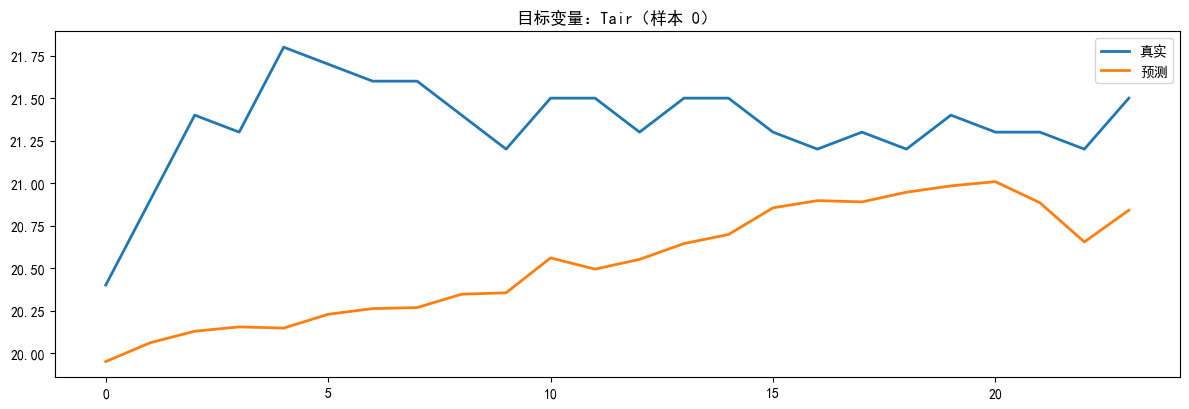

In [15]:
# ========= 11) 复现截图：真实 vs 预测 曲线（目标变量：Tair，样本 0） =========
# 说明：
# - 这里默认用 TPLCNet 的训练后模型 tplc_model 做预测
# - y / y_hat 在数据集中是“标准化空间”，这里会用 train 的 scaler 反标准化回原始量纲

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.utils import NumpyStandardScaler

# 兜底检查：确保前面的训练 cell 已经跑完
required = ['tplc_model', 'test_loader', 'target_cols', 'feature_cols', 'all_scaler', 'device', 'pred_len']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"缺少变量 {missing}，请先按顺序运行前面的训练/数据单元。")

# 选择目标变量：优先 Tair
var_name = 'Tair' if 'Tair' in target_cols else target_cols[0]
var_idx = target_cols.index(var_name)

# 从 all_scaler 派生 target_scaler（与 run_TPLC_greenhouse.ipynb 一致）
target_indices = [feature_cols.index(c) for c in target_cols]
target_scaler = NumpyStandardScaler(mean_=all_scaler.mean_[target_indices], std_=all_scaler.std_[target_indices])

# 取一个 batch，画样本 0
sample = 0
x, y = next(iter(test_loader))
x = x.to(device)

tplc_model.eval()
with torch.no_grad():
    y_hat = tplc_model(x).detach().cpu().numpy()  # [B, pred_len, target_dim]

# y 是标准化空间；先转 numpy 再反标准化
y_true = y.detach().cpu().numpy()

y_hat_inv = target_scaler.inverse_transform(y_hat.reshape(-1, len(target_cols))).reshape(y_hat.shape)
y_true_inv = target_scaler.inverse_transform(y_true.reshape(-1, len(target_cols))).reshape(y_true.shape)

fig = plt.figure(figsize=(12, 4.2))
plt.plot(y_true_inv[sample, :, var_idx], label='真实', linewidth=2.0)
plt.plot(y_hat_inv[sample, :, var_idx], label='预测', linewidth=2.0)
plt.title(f'目标变量：{var_name}（样本 {sample}）')
plt.legend()
plt.tight_layout()
plt.show()

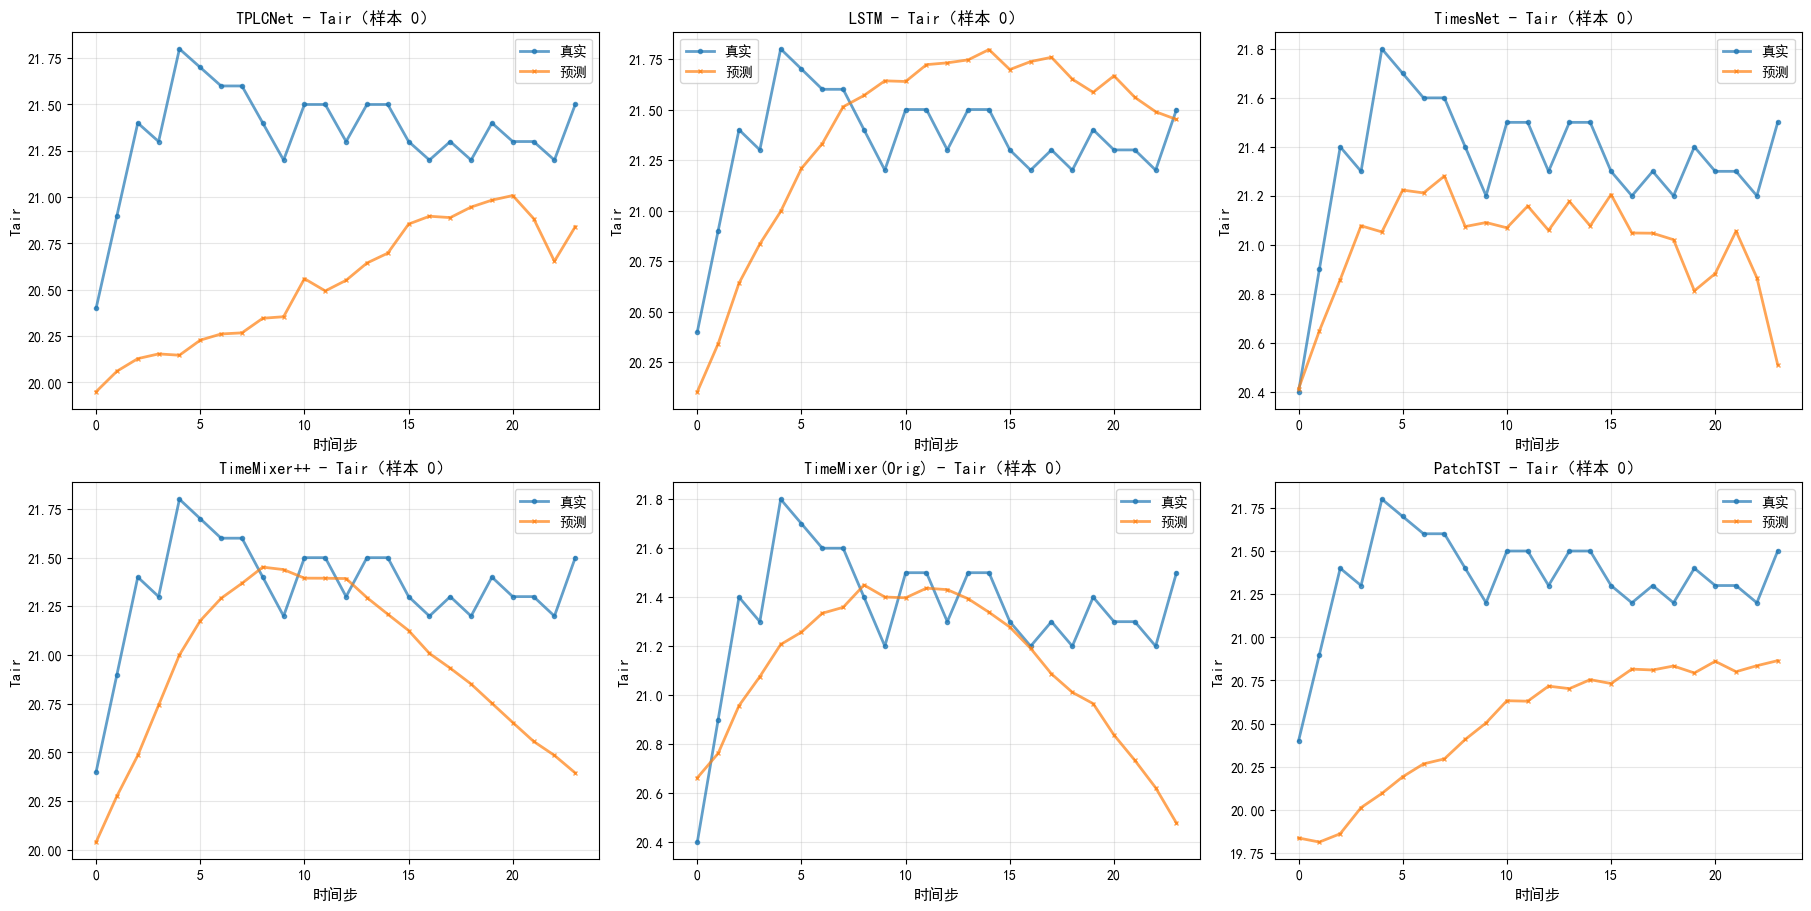

In [16]:
# ========= 13) 多模型预测对比可视化（目标变量：Tair，样本 0） =========
import matplotlib.pyplot as plt
import math
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 确保所有模型已训练
required_models = ['tplc_model', 'lstm_model', 'timesnet_model', 'tm_model', 'tm_orig_model']
if PatchTSTModel is not None:
    required_models.append('patchtst_model')

missing_models = [m for m in required_models if m not in globals()]
if missing_models:
    print(f"警告: 部分模型未找到 ({missing_models})，将只绘制已有的模型。")

# 复用前面的 batch
if 'x' not in globals() or 'y' not in globals():
    x, y = next(iter(test_loader))

x_device = x.to(device)
y_true = y.detach().cpu().numpy() if hasattr(y, 'detach') else np.asarray(y)

# 收集模型预测
predictions = {}

model_list = [
    ('TPLCNet', tplc_model), 
    ('LSTM', lstm_model), 
    ('TimesNet', timesnet_model),
    ('TimeMixer++', tm_model),
    ('TimeMixer(Orig)', tm_orig_model)
]
if PatchTSTModel is not None and 'patchtst_model' in globals():
    model_list.append(('PatchTST', patchtst_model))

with torch.no_grad():
    for name, model in model_list:
        model.eval()
        # 处理不同模型的输入差异（如有）
        y_hat = model(x_device).detach().cpu().numpy()
        
        # 反标准化
        y_hat_inv = target_scaler.inverse_transform(y_hat.reshape(-1, len(target_cols))).reshape(y_hat.shape)
        predictions[name] = y_hat_inv

# 反标准化真实值
y_true_inv = target_scaler.inverse_transform(y_true.reshape(-1, len(target_cols))).reshape(y_true.shape)

# 绘图对比
num_models = len(predictions)
cols = 3
rows = math.ceil(num_models / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4.5 * rows), constrained_layout=True)

# 展平 axes 以便遍历
axes_flat = axes.flatten() if num_models > 1 else [axes]

for i, (model_name, y_hat_inv) in enumerate(predictions.items()):
    ax = axes_flat[i]
    ax.plot(y_true_inv[sample, :, var_idx], label='真实', linewidth=2.0, marker='o', markersize=3, alpha=0.7)
    ax.plot(y_hat_inv[sample, :, var_idx], label='预测', linewidth=2.0, marker='x', markersize=3, alpha=0.7)
    ax.set_title(f'{model_name} - {var_name}（样本 {sample}）', fontsize=12)
    ax.set_xlabel('时间步', fontsize=11)
    ax.set_ylabel(var_name, fontsize=11)
    ax.legend()
    ax.grid(alpha=0.3)

# 隐藏多余的子图
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.show()